In [6]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [9]:
# Load model
model = models.resnet50(pretrained=True)
model.eval()

# Target layer for Grad CAM
target_layer = model.layer4[-1].conv3
features = None
gradients = None

def hook_features(module, input, output):
    global features
    features = output

def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Register hooks
target_layer.register_forward_hook(hook_features)
target_layer.register_backward_hook(hook_gradients)

# Load and preprocess image
img_path = "x.png"  # Replace with your image path
img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0)

# Forward pass
output = model(input_tensor)
class_idx = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, class_idx].backward()

# Generate CAM
weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
cam = torch.sum(weights * features, dim=1).squeeze().detach().cpu().numpy()
cam = np.maximum(cam, 0)  # ReLU
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)  # Normalize

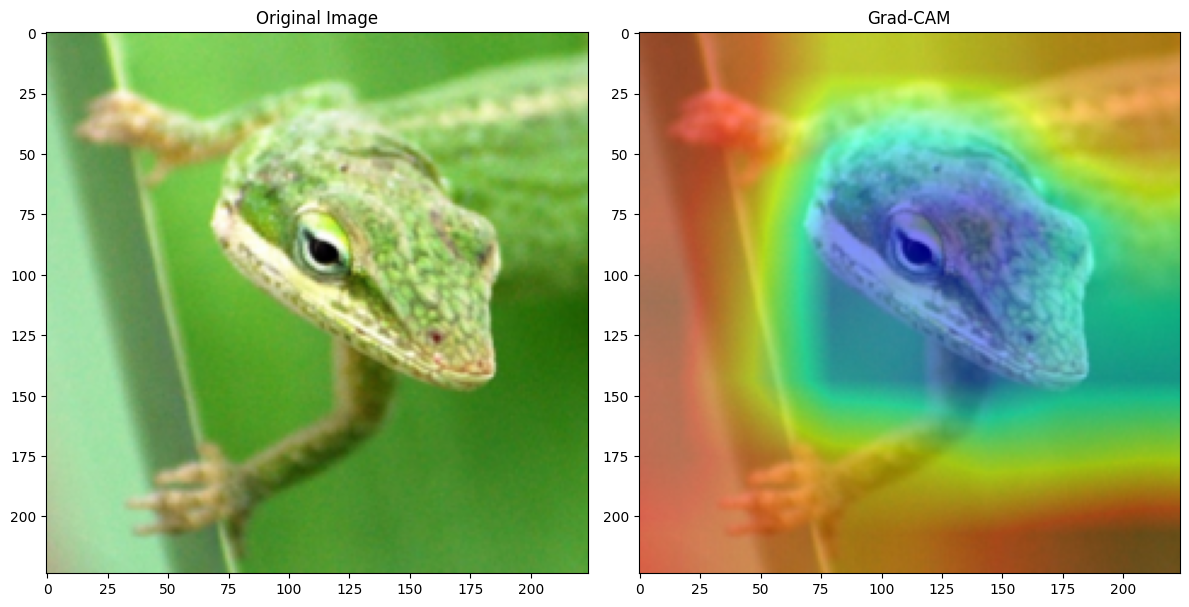

In [10]:
# Create heatmap
original = np.array(img.resize((224, 224))) / 255.0
cam = cv2.resize(cam, (original.shape[1], original.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
result = heatmap + np.float32(original)
result = result / np.max(result)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original)
plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(result)
plt.tight_layout()
plt.show()